<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase2/blob/master/EVA4P2_S2_MobilenetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! nvidia-smi

Thu Jul 30 14:08:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
import random
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
sns.set()
print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.1+cu101


In [6]:
%%time
from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/ThumbnailData.zip', mode='r') as input:
  input.extractall('.')

CPU times: user 1.3 s, sys: 880 ms, total: 2.18 s
Wall time: 4.03 s


In [7]:
def prepare_data(root, classes):
  finaldata = []
  for i in range(len(classes)):
    path = root + '/' + classes[i] + '/'
    data_rec = [(path+file_name, i) for file_name in os.listdir(path)]
    finaldata.extend(data_rec) 
  random.shuffle(finaldata)
  return finaldata

In [8]:
class_names = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
dataset = prepare_data('/content/Data',class_names)
print(f'Dataset Length:{len(dataset)}, Train Data length: {int(len(dataset)*0.7)},Test Data length: {int(len(dataset)*0.3)}')
train_len = int(len(dataset)*0.7)

Dataset Length:19318, Train Data length: 13522,Test Data length: 5795


In [9]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase2

Cloning into 'Deep_Learning_EVA4_Phase2'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 297 (delta 22), reused 0 (delta 0), pack-reused 234
Receiving objects: 100% (297/297), 256.12 KiB | 10.67 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [10]:
%cd '/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda'
! ls

/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda
README.md  src


In [11]:
os.chdir('/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import customdataset as cds
from src.dataset import Alb_data_transforms as Alb
from src.models  import S15_FGDepth_models as ntwk
from src.losses  import Train_Losses
from src.losses  import Test_Losses
from src.utils   import Freeze_Layers as Freeze

In [12]:
import albumentations as A
channel_means  = (0.48043839, 0.44820218, 0.39760034)
channel_stdevs = (0.27698959, 0.26908774, 0.28216029)
# Train Phase transformations
train_transforms = Alb.Albumentations_transform([
                                      A.Rotate((-30.0, 30.0)),
                                      A.HorizontalFlip(),
                                      A.Resize(224, 224),
                                      A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=56, max_w_size=56), # fillvalue is 0 after normalizing as mean is 0
                                    ])

fillmeans = (np.array(channel_means)).astype(np.uint8)

# Test Phase transformations
test_transforms = Alb.Albumentations_transform([A.Resize(224, 224),
                                                A.Normalize(mean=channel_means, std=channel_stdevs),])

In [13]:
train = cds.Customdataset(dataset[:train_len],train_transforms)
test  = cds.Customdataset(dataset[train_len:],test_transforms)
print(f'Train Length {len(train)}, Test Length {len(test)}')

Train Length 13522, Test Length 5796


In [14]:
train_loader  = DataLoader(train, batch_size = 32,shuffle = True, pin_memory = True)
test_loader   = DataLoader(test, batch_size = 32, shuffle = True, pin_memory = True)

In [15]:
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  print(img.shape)
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i]) + channel_means[i]
  return np.transpose(img, (1,2,0))

In [16]:
dataiter = iter(test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

To check if images are coming out correctly as batches, images.shape: torch.Size([32, 3, 224, 224]), labels.shape: torch.Size([32])
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)


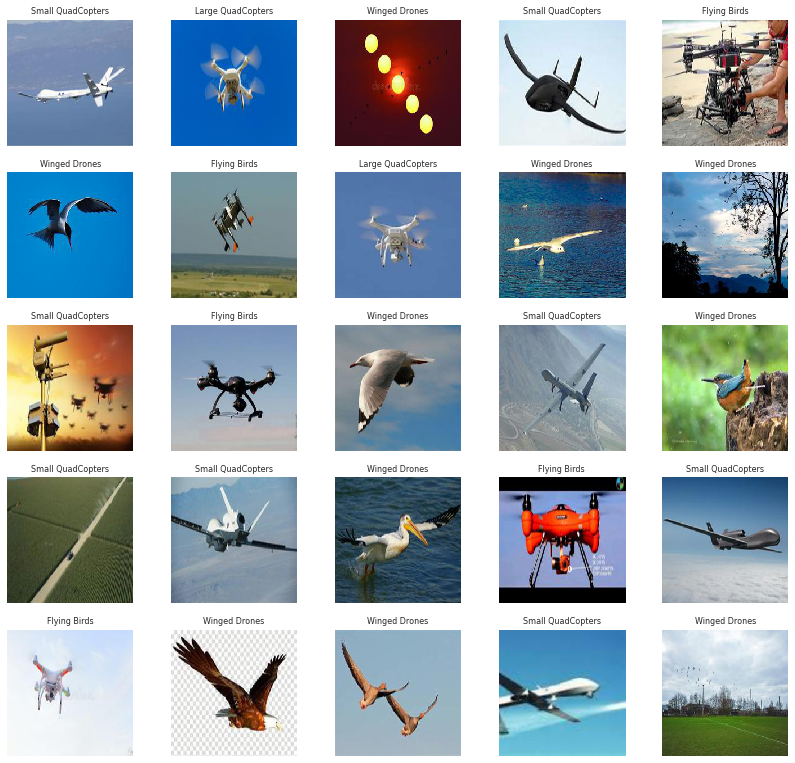

In [17]:
images, labels = dataiter.next()
print(f'To check if images are coming out correctly as batches, images.shape: {images.shape}, labels.shape: {labels.shape}')
num_classes = len(class_names)
r, c = 5, 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax  = plt.subplot(r,c, idx + 1)
    ax.set_title(class_names[labels[idx]-1][:30], fontdict={'fontsize':8})
    plt.axis('off')
    ax.imshow(unnormalize(images[idx]), interpolation ='none')
plt.show()    

In [18]:
!pip install torchsummary
from torchsummary import summary
model = torch.hub.load('pytorch/vision:v0.6.0','mobilenet_v2',pretrained=True)
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 224, 224))

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96

In [19]:
for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=4).to("cuda")
model.features[16].requires_grad  = True
model.features[17].requires_grad  = True
model.features[18].requires_grad  = True
model.classifier[0].requires_grad = True
model.classifier[1].requires_grad = True

In [20]:
model.to(model.device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [21]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_Losses.Test_loss()

In [22]:
#freezer = Freeze.Freezer()

In [23]:
for name, module in model.named_modules():
    print('name:',name)

name: 
name: features
name: features.0
name: features.0.0
name: features.0.1
name: features.0.2
name: features.1
name: features.1.conv
name: features.1.conv.0
name: features.1.conv.0.0
name: features.1.conv.0.1
name: features.1.conv.0.2
name: features.1.conv.1
name: features.1.conv.2
name: features.2
name: features.2.conv
name: features.2.conv.0
name: features.2.conv.0.0
name: features.2.conv.0.1
name: features.2.conv.0.2
name: features.2.conv.1
name: features.2.conv.1.0
name: features.2.conv.1.1
name: features.2.conv.1.2
name: features.2.conv.2
name: features.2.conv.3
name: features.3
name: features.3.conv
name: features.3.conv.0
name: features.3.conv.0.0
name: features.3.conv.0.1
name: features.3.conv.0.2
name: features.3.conv.1
name: features.3.conv.1.0
name: features.3.conv.1.1
name: features.3.conv.1.2
name: features.3.conv.2
name: features.3.conv.3
name: features.4
name: features.4.conv
name: features.4.conv.0
name: features.4.conv.0.0
name: features.4.conv.0.1
name: features.4.c

In [26]:
path = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_0730V1.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [27]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH         = 5
L2_factor     = 0.0001
L1_factor     = 0.0005
least_loss_lr = 0.03

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []

OPTIMIZER = optim.SGD(model.parameters(),lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode='min',factor=0.1, min_lr=1e-7, patience =4, verbose=True)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCH):
  print('\nEPOCH:', epoch)
  train_losses, train_acc = train_loss.train_loss_calc(model,model.device,train_loader=train_loader,optimizer=OPTIMIZER,
                                                       epoch=EPOCH, factor=L1_factor,criterion=criterion,
                                                       scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
  test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct = \
                            test_loss.test_loss_calc(model,model.device,test_loader=test_loader,optimizer=OPTIMIZER,
                                                     total_epoch=EPOCH,current_epoch=epoch,criterion=criterion,
                                                     scheduler=SCHEDULER) 
  train_loss_all.extend(train_losses)
  train_acc_all.extend(train_acc)
  test_loss_all.extend(test_losses)
  test_acc_all.extend(test_acc)

  if len(test_loss_all) > 1:
    loss_decrease = 0
    loss_decrease = test_loss_all[-2] - test_loss_all[-1]
    if loss_decrease > 0:
      print(f'Test Loss -> Decreasing, Prev Loss:{test_loss_all[-2]:.6f}, Latest Loss:{test_loss_all[-1]:.6f}, Delta:{loss_decrease:.6f}')
    else:
      print(f'Test Loss -> Increasing, Prev Loss:{test_loss_all[-2]:.6f}, Latest Loss:{test_loss_all[-1]:.6f}, Delta:{loss_decrease:.6f}')  

  #if loss_decrease < 0.0001:
  if epoch%4 == 0:
    print(f' **** Model Saved in epoch:{epoch}')
    path_model_save = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_0730V1.pt'
    torch.save(model.state_dict(),path_model_save)

Train Loss = 1.244658350944519 Batch Id = 0 Train Acc = 81.25 LR =0.030000:   0%|          | 1/423 [00:00<01:04,  6.52it/s]


EPOCH: 0


Train Loss = 2.3958733081817627 Batch Id = 422 Train Acc = 72.48 LR =0.030000: 100%|██████████| 423/423 [00:57<00:00,  7.30it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Test Accuracy: 78.90, LR : 0.030000
 **** Model Saved in epoch:0

EPOCH: 1


Train Loss = 3.102217197418213 Batch Id = 422 Train Acc = 72.06 LR =0.030000: 100%|██████████| 423/423 [00:58<00:00,  7.28it/s]
Train Loss = 1.7893221378326416 Batch Id = 0 Train Acc = 71.88 LR =0.030000:   0%|          | 1/423 [00:00<01:00,  6.93it/s]


Test set: Average loss: 0.0547, Test Accuracy: 76.86, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.031821, Latest Loss:0.054684, Delta:-0.022863

EPOCH: 2


Train Loss = 1.8509469032287598 Batch Id = 422 Train Acc = 71.68 LR =0.030000: 100%|██████████| 423/423 [00:58<00:00,  7.28it/s]
Train Loss = 2.165921926498413 Batch Id = 0 Train Acc = 71.88 LR =0.030000:   0%|          | 1/423 [00:00<01:04,  6.54it/s]


Test set: Average loss: 0.0408, Test Accuracy: 78.21, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.054684, Latest Loss:0.040786, Delta:0.013898

EPOCH: 3


Train Loss = 2.0918421745300293 Batch Id = 422 Train Acc = 71.95 LR =0.030000: 100%|██████████| 423/423 [00:58<00:00,  7.27it/s]
Train Loss = 0.9158177375793457 Batch Id = 0 Train Acc = 78.12 LR =0.030000:   0%|          | 1/423 [00:00<01:05,  6.44it/s]


Test set: Average loss: 0.0319, Test Accuracy: 81.44, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.040786, Latest Loss:0.031890, Delta:0.008896

EPOCH: 4


Train Loss = 2.063241958618164 Batch Id = 422 Train Acc = 72.27 LR =0.030000: 100%|██████████| 423/423 [00:58<00:00,  7.28it/s]



Test set: Average loss: 0.0332, Test Accuracy: 79.80, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.031890, Latest Loss:0.033248, Delta:-0.001358
 **** Model Saved in epoch:4


In [55]:
for param in model.features[0].parameters():
    param.requires_grad = False

In [54]:
print(model.features[0])

ConvBNReLU(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)


In [ ]:
def freeze_mask_layers():
    print('Freezing Mask Layers')
    for param in model.features.0.parameters():
      param.requires_grad = False
    for param in model.convB.parameters():
      param.requires_grad = False
    for param in model.convC.parameters():
      param.requires_grad = False
    for param in model.convD.parameters():
      param.requires_grad = False
    for param in model.convE.parameters():
      param.requires_grad = False
    #    
    for param in model.blck1.parameters():
      param.requires_grad = True
    for param in model.blck2.parameters():
      param.requires_grad = True
    for param in model.blck3.parameters():
      param.requires_grad = True
    for param in model.blck4.parameters():
      param.requires_grad = True
    for param in model.blck5.parameters():
      param.requires_grad = True  
    for param in model.blck6.parameters():
      param.requires_grad = True
    for param in model.blck7.parameters():
      param.requires_grad = True
    for param in model.blck8.parameters():
      param.requires_grad = True
    for param in model.convLast.parameters():
      param.requires_grad = True          

In [ ]:
def freeze_depth_layers():
    print('Freezing Depth Layers')
    for param in model.convA.parameters():
      param.requires_grad = True
    for param in model.convB.parameters():
      param.requires_grad = True
    for param in model.convC.parameters():
      param.requires_grad = True
    for param in model.convD.parameters():
      param.requires_grad = True
    for param in model.convE.parameters():
      param.requires_grad = True  
    #    
    for param in model.blck1.parameters():
      param.requires_grad = False
    for param in model.blck2.parameters():
      param.requires_grad = False
    for param in model.blck3.parameters():
      param.requires_grad = False
    for param in model.blck4.parameters():
      param.requires_grad = False
    for param in model.blck5.parameters():
      param.requires_grad = False  
    for param in model.blck6.parameters():
      param.requires_grad = False
    for param in model.blck7.parameters():
      param.requires_grad = False
    for param in model.blck8.parameters():
      param.requires_grad = False
    for param in model.convLast.parameters():
      param.requires_grad = False    

In [ ]:
path = f'/content/gdrive/My Drive/FG_Depth_Prediction_0525V11C.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>